In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import sympy as sp
import time

In [16]:
# Definition of the potential

# Parameters of the potential
a = 0.02
x_min = 10 # Position of the second minimum, with U(x_min)=(a*x_min**3*c**2)/(x_min+2*c),
          # the first minimum is in x=0, with f(0)=0  
c = 5

def potential (x, a=a, x_min=x_min, c=c):
    U = a*(x-x_min)**2*(x-c)*(x+(x_min*c)/(x_min+2*c)) + (a*x_min**3*c**2)/(x_min+2*c)
    return U

In [17]:
# Definition of the pulling force seen as the gradient of an armonic potential of the form: 
# F = (k/2)*(x-x_0)**2, where 'k' is the analogous of the elastic constant, and x_0 is the position of the minimum

k=10
x_center=0
def external_force(x, x_center, k=k):
    return -k*(x-x_center)


In [18]:
# Parameters
n_tries = 30
x_center = 0
total_time = 100
dt = 0.005
v_external_force = x_min/total_time
n_steps= round(total_time/dt)
gamma= 100 # friction coefficient 
kbT=1
D = kbT/gamma

std = 1/np.sqrt(2*((a*x_min)/(x_min+2*c)*(3*c**2+x_min**2+2*x_min*c)+k/2)/kbT)


In [19]:
# Definition of the initial probability function (Boltzmann distribution)

def eq_distribution_in(x):
    p = np.exp((-potential(x)-(k/2)*(x-x_center)**2)/kbT)
    return p

# Second order approximation (gaussian)
def approx_in(x):
    p = np.exp((-((a*x_min)/(x_min+2*c)*(3*c**2+x_min**2+2*x_min*c)+k/2)*x**2)/kbT)
    return p


In [20]:
# Definition of the final probability function (Boltzmann distribution)

def eq_distribution_fin(x):
    p = np.exp((-potential(x)-(k/2)*(x-x_min)**2)/kbT)
    return p

# Second order approximation (gaussian)
def approx_fin(x):
    p = np.exp((-(a*(x_min-c)*(x_min+ (x_min*c)/(x_min+2*c)) + k/2)*(x-x_min)**2 - (a*x_min**3*c**2)/(x_min+2*c))/kbT)
    return p
std_fin = 1/np.sqrt(2*((a*x_min)/(x_min+2*c)*(3*c**2+x_min**2+2*x_min*c)+k/2)/kbT)

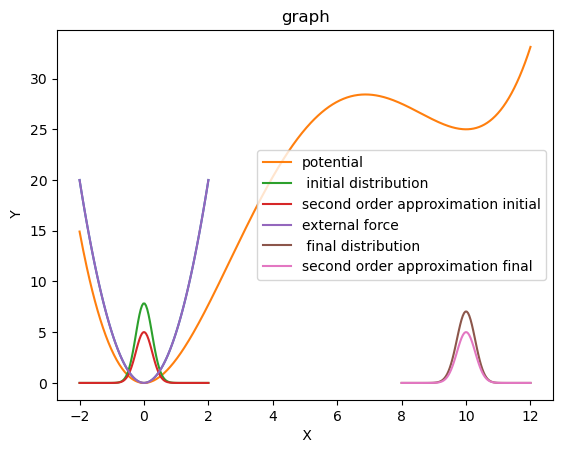

0.6367845635316493 0.45148147875792755 9.847135204191375e-12 25.343840545261422


In [21]:
# Plot


# Creazione del plot iniziale
fig, ax = plt.subplots()

x = np.linspace(-0.2*x_min, 1.2*x_min, 500)  
x_force = np.linspace(x_center-2, x_center+2, 100)
x_final = np.linspace(x_min-2, x_min+2, 100)

line, = ax.plot(x_force, k/2*(x_force-x_center)**2)

integral_in, _ = integrate.quad(eq_distribution_in , -5, 5)
int_approx_in, _ = integrate.quad(approx_in , -5, 5)
free_energy_in = - kbT * np.log(int_approx_in)

integral_fin, _ = integrate.quad(eq_distribution_fin , -5+x_min, 5+x_min)
int_approx_fin, _ = integrate.quad(approx_fin , -5+ x_min, 5+ x_min)
free_energy_fin = - kbT * np.log(integral_fin)

plt.plot(x, potential(x), label='potential')
plt.plot(x_force,  5*eq_distribution_in(x_force)/integral_in, label=' initial distribution') # it's multiplied to be able to see it
#plt.plot(x_force, 5*approx_in(x_force)/int_approx_in, label='second order approximation initial')
plt.plot(x_force,  5*approx_in(x_force)/np.max(approx_in(x_force)), label='second order approximation initial')
plt.plot(x_force,k/2*(x_force-x_center)**2, label='external force')
plt.plot(x_final,  5*eq_distribution_fin(x_final)/integral_fin, label=' final distribution') # it's multiplied to be able to see it
#plt.plot(x_final,  5*approx_fin(x_final)/int_approx_fin, label='second order approximation final')
plt.plot(x_final,  5*approx_fin(x_final)/np.max(approx_fin(x_final)), label='second order approximation final')

plt.legend()

plt.title('graph')
plt.xlabel(' X')
plt.ylabel(' Y')
plt.show()
print(integral_in,free_energy_in, integral_fin, free_energy_fin)



In [22]:
# Variation of free energy

d_free_energy = free_energy_fin - free_energy_in
print(d_free_energy)

24.892359066503495


In [23]:
# Total F_ext (calculated with symbolic derivative):
x_ = sp.symbols('x_')
pot = a*(x_-x_min)**2*(x_-c)*(x_+(x_min*c)/(x_min+2*c)) + (a*x_min**3*c**2)/(x_min+2*c)
# Symbolic derivative
derivative = sp.diff(pot, x_)

def F_tot(x,x_center):
    F = external_force(x, x_center) - derivative.subs(x_,x)
    return F

In [24]:
# Define the iteration process 
def iteration (x_in, x_center, v_external_force=v_external_force, gamma=gamma, kbT=kbT, dt=dt):
    rand = np.random.normal()
    
    # Explicit Euler
    #x_new = x_in + F_tot(x_in, x_center)/gamma * dt + np.sqrt(2*D*dt)*rand
   
    #print(np.sqrt(2*D*dt)*rand)
    
    #print(external_force(x_in, x_center)/gamma*dt, (F_tot(x_in, x_center)-external_force(x_in, x_center))/gamma * dt, np.sqrt(2*D*dt)*rand, x_in)
    # Runge-kutta               
    k1x = F_tot(x_in, x_center) / gamma * dt + np.sqrt(2 * D * dt) * rand
    k2x = F_tot(x_in + k1x / 2, x_center + v_external_force*dt/2) / gamma * dt + np.sqrt(2 * D * dt) * rand
    k3x = F_tot(x_in + k2x / 2, x_center + v_external_force*dt/2) / gamma * dt + np.sqrt(2 * D * dt) * rand
    k4x = F_tot(x_in + k3x, x_center) / gamma * dt + np.sqrt(2 * D * dt) * rand 

    x_new = x_in + (k1x + 2 * k2x + 2 * k3x + k4x) / 6 
    
   
    return x_new


In [25]:
print(x_center)
print(std)

0
0.254000254000381


In [26]:
# Calculation of trajectory

# Inizialization
w = np.zeros(n_tries) # collect the work done
x_center=0
x_sim = np.zeros(n_steps+1)
x_in = np.zeros(n_tries)
x_fin = np.zeros(n_tries)
# Total F_ext (calculated with symbolic derivative):
x_ = sp.symbols('x_')
pot = a*(x_-x_min)**2*(x_-c)*(x_+(x_min*c)/(x_min+2*c)) + (a*x_min**3*c**2)/(x_min+2*c)
# Symbolic derivative
derivative = sp.diff(pot, x_)
# Integration
start_time = time.time()
for j in range(n_tries):
    
    x_sim[0] = np.random.normal(0,std)
    x_center = 0
    
    for i in range(1, n_steps+1):
        
        x_sim[i] = iteration(x_sim[i-1], x_center)
                                                         
        w[j] += external_force((x_sim[i-1]+x_sim[i])/2,x_center +v_external_force * dt/2)*(x_sim[i]-x_sim[i-1])
        
        
        
        #print(x_sim[i], x_sim[i]-x_sim[i-1], external_force(x_sim[i-1], x_center), F_tot(x_sim[i-1],x_center)-external_force(x_sim[i-1],x_center), F_tot(x_sim[i-1],x_center))
        x_center += v_external_force*dt
        

 
    x_fin[j]=x_sim[-1]
    x_in[j]=x_sim[0]
    print(x_in[j], x_fin[j], w[j], potential(x_fin[j])- potential(x_in[j]))
   
   
end_time = time.time()
execution_time = end_time - start_time


print(f"Tempo totale di esecuzione: {execution_time} secondi")


0.14793985084106998 9.81936082935261 29.45639483954878 24.980006810417752
Tempo totale di esecuzione: 218.78706288337708 secondi


In [27]:
print(kbT, dt, total_time, x_center)

1 0.005 100 10.00000000000073


In [28]:
print (x_fin, np.sqrt(2*D*total_time), w)

[9.81936083] 14.142135623730951 [29.45639484]


In [29]:
invalid_indexes=np.where(np.isnan(w))
print(len(invalid_indexes[0]))

0


In [30]:
exp_w = np.exp(- w / kbT)
print(np.mean(w))

29.45639483954878


In [31]:
w_1 = np.copy(w)
x_fin_1= np.copy(x_fin)
x_in_1 = np.copy(x_in)

In [32]:
print(w_1.size,w.size, len(invalid_indexes[0]), x_in_1.size, x_fin_1.size)
x_in_1

1 1 0 1 1


array([0.14793985])

In [33]:
w_1 = np.delete(w_1,invalid_indexes)
x_fin_1 = np.delete(x_fin_1,invalid_indexes)
x_in_1 = np.delete (x_in_1,invalid_indexes)

In [34]:
print(np.mean(w_1))

29.45639483954878


In [35]:
exp_w_1 = np.exp(- (w_1-np.min(w_1))/kbT)

print(exp_w_1[:10])

[1.]


In [36]:
print(np.mean(w_1))

29.45639483954878


Text(0.5, 1.0, ' Langevin Simulation')

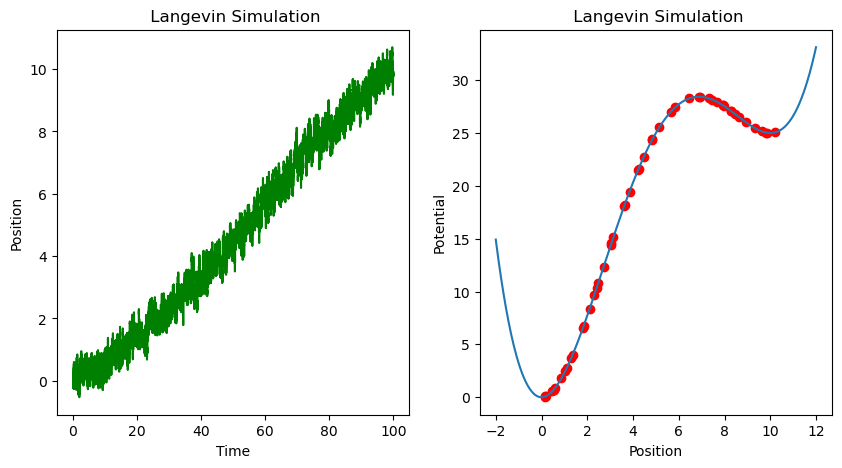

In [37]:
tim_ = np.linspace(0,total_time , x_sim.size)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(tim_, x_sim, 'g')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[0].set_title(' Langevin Simulation')

x_plot=x_sim[::int(len(x_sim)/50)] # plots only 50 points
axs[1].plot(x_plot,potential(x_plot), 'ro', label='simulation')
axs[1].plot(x, potential(x), label='potential')
axs[1].set_xlabel('Position')
axs[1].set_ylabel('Potential')
axs[1].set_title(' Langevin Simulation')

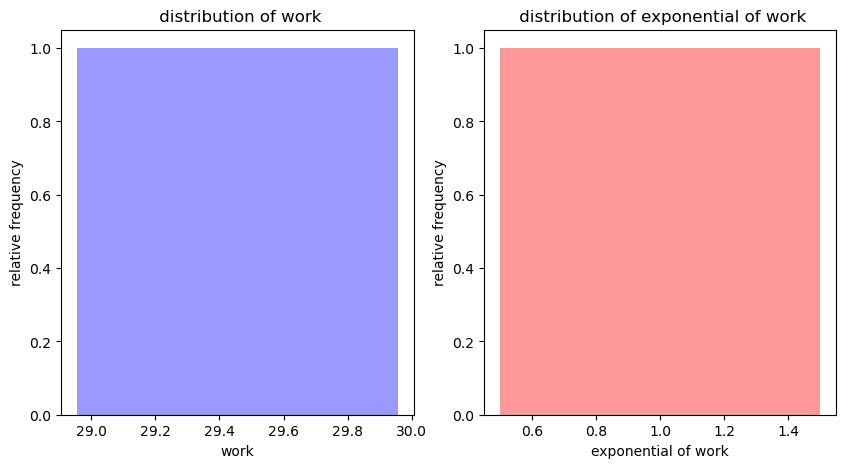

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].hist(w_1, bins=round(np.sqrt(w_1.size)), alpha=0.4, color='blue', label='work', density=True)
axs[0].set_xlabel('work')
axs[0].set_ylabel('relative frequency')
axs[0].set_title(' distribution of work')


axs[1].hist(exp_w_1, bins=round(np.sqrt(w_1.size)), alpha=0.4, color='red', label='exponential of work', density=False)
axs[1].set_xlabel('exponential of work')
axs[1].set_ylabel('relative frequency')
axs[1].set_title(' distribution of exponential of work')

plt.show()

In [39]:
print(np.mean(exp_w_1)*np.exp(-np.min(w_1)/kbT), np.exp(-d_free_energy/kbT))

1.6115740454534652e-13 1.546627813126299e-11


In [40]:
def write_vectors_to_file(file_path, vectors):
    with open(file_path, 'w') as file:
        file.write('x_iniziale'+'\t'+' x_finale'+' \t'+' lavoro' + '\n')
        for i in range(len(vectors[0])):
            # Estrai gli elementi dalla stessa posizione in ciascun vettore
            column_values = [vector[i] for vector in vectors]
            
            # Converti gli elementi della colonna in stringhe e uniscili con uno spazio
            column_str = ' '.join(map(str, column_values))
            
            # Scrivi la colonna nel file
            file.write(column_str + '\n')

# Example usage
vectors = [x_in_1, x_fin_1, w_1]

file_path = 'results.txt'
write_vectors_to_file(file_path, vectors)

In [41]:
import csv
import numpy as np

kbT= 2
x_in = np.array([])
x_fin = np.array([])
w = np.array([])

with open('kbT2a02x_min10c5.txt', 'r') as file:
  
    reader = csv.reader(file, delimiter=' ')
    next(reader)

    
    for row in reader:
        
        col1 = float(row[0])
        col2 = float(row[1])
        col3 = float(row[2])


        x_in = np.append(x_in, col1)
        x_fin = np.append(x_fin, col2)
        w = np.append(w, col3)

FileNotFoundError: [Errno 2] No such file or directory: 'kbT2a02x_min10c5.txt'

In [ ]:
exp_work = np.exp(-(w-np.min(w))/kbT)
#print(exp_work)
print(np.mean(w), d_free_energy , (a*x_min**3*c**2)/(x_min+2*c))
print(np.min(w), np.max(w), np.mean(w))
print(np.std(x_in))
std_fin = 1/np.sqrt(2*((a*x_min)/(x_min+2*c)*(3*c**2+x_min**2+2*x_min*c)+k/2)/kbT)
print(np.mean(x_fin), np.std(x_fin), 1/np.sqrt(2)*std_fin)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].hist(w, bins=round(np.sqrt(len(w))), alpha=0.4, color='blue', label='work', density=True)
axs[0].set_xlabel('work')
axs[0].set_ylabel('relative frequency')
axs[0].set_title(' distribution of work')


axs[1].hist(np.exp(-w/kbT), bins=round(np.sqrt(len(w))), alpha=0.4, color='red', label='exponential of work', density=False)
axs[1].set_xlabel('exponential of work')
axs[1].set_ylabel('relative frequency')
axs[1].set_title(' distribution of exponential of work')

In [ ]:
print(np.mean(exp_work)*np.exp(-np.min(w)/kbT), np.exp(-d_free_energy/kbT))